In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [2]:
df=pd.read_csv('model_data.csv')

In [3]:
df.drop(columns=['GT_vs_AI','MA_vs_AI','date','Unnamed: 0'],inplace=True)

In [4]:
#Lets see how many observations we have for every variety
for i in range(0,7):
    print(df[df['variety']== i].shape)

(30, 7)
(29, 7)
(90, 7)
(60, 7)
(20, 7)
(69, 7)
(120, 7)


In [5]:
# Working only with the variety of Merlot
test_df_Merlot = df[df['variety'] == 2]

## Quantile Function

In [6]:
predicted_counts = test_df_Merlot['AI detections']
ground_truth = test_df_Merlot['Ground Truth']

# Calculate quantiles
predicted_quantiles = np.percentile(predicted_counts, np.arange(0, 101))
ground_truth_quantiles = np.percentile(ground_truth, np.arange(0, 101))

# Quantile mapping function
def quantile_mapping(prediction, predicted_quantiles, ground_truth_quantiles):
    mapped_quantile = np.interp(np.percentile(prediction, np.arange(0, 101)),
                                predicted_quantiles, ground_truth_quantiles)
    mapped_prediction = np.interp(prediction, predicted_quantiles, mapped_quantile)
    return mapped_prediction

# Apply quantile mapping
adjusted_counts = quantile_mapping(predicted_counts, predicted_quantiles, ground_truth_quantiles)

In [7]:
test_df_Merlot['Modified Values']=adjusted_counts

## Mean Function

## Sequential Model

In [8]:
X=test_df_Merlot.drop(columns=['Tree','Ground Truth','Number of manual annotations'])
y=test_df_Merlot['Ground Truth']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [11]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))


model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))




model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error' )

In [12]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[reduce_lr, early_stopping])
predictions = model.predict(X_test)
loss_MSE = model.evaluate(X_test, y_test)
print(f' Loss_MSE: {loss_MSE}')

Epoch 1/100

2/2 [==============================] - 1s 212ms/step - loss: 598.2364 - val_loss: 245.4536 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 52ms/step - loss: 444.3409 - val_loss: 138.9465 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 53ms/step - loss: 252.3367 - val_loss: 82.4785 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 40ms/step - loss: 252.1294 - val_loss: 70.9297 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 45ms/step - loss: 144.4338 - val_loss: 86.3337 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 43ms/step - loss: 182.1401 - val_loss: 101.5134 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 32ms/step - loss: 30.2245
 Loss_MSE: 30.22450828552246


In [13]:
pred_df=pd.DataFrame()
pred_df['Ground Truth']=y_test
pred_df['AI']=X_test['AI detections']
pred_df['Predictions']=predictions
pred_df['adjust']=X_test['Modified Values']
pred_df['GS']=X_test['GS']

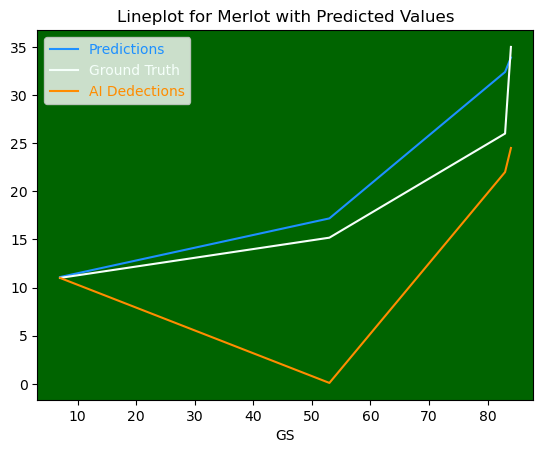

In [14]:
grouped_data =pred_df.groupby('GS')['Predictions','Ground Truth','AI'].mean()
ax = grouped_data.plot()
line_colors = ["dodgerblue",'mintcream',"darkorange"]
for i, line in enumerate(ax.lines):
    line.set_color(line_colors[i])
ax.patch.set_facecolor('darkgreen')
legend_labels = ['Predictions','Ground Truth','AI Dedections']
for i, text in enumerate(ax.legend().get_texts()):
    text.set_color(line_colors[i])
    text.set_text(legend_labels[i])
plt.title('Lineplot for Merlot with Predicted Values')
plt.savefig("Lineplot for Merlot Predicted Values.png")
plt.show()